**Dataset source**: https://www.kaggle.com/datasets/devarajv88/delhivery-logistics-dataset  
The dataset is about Delhivery's logistics operations in India. 

**Column description:**  

**data**: Tells whether the data is testing or training data.  
**trip_creation_time**: Timestamp of trip creation.  
**route_schedule_uuid**: Unique Id for a particular route schedule.  
**route_type**: Transportation type. Includes 2 types: Carting and FTL. FTL shipments get to the destination sooner, as the truck is making no other pickups or drop-offs along the way.  
**Carting**: Handling system consisting of small vehicles (carts).  
**trip_uuid**: Unique ID given to a particular trip (A trip may include different source and destination centers).  
**source_center**: Source ID of trip origin.  
**source_name**: Source Name of trip origin.  
**destination_center**: Destination ID.  
**destination_name**: Destination Name.  
**od_start_time**: Trip start time.  
**od_end_time**: Trip end time.  
**start_scan_to_end_scan**: Time taken to deliver from source to destination.  
**is_cutoff**: Not the end of the subset of the package delivery.  
**cutoff_factor**: Unknown field.  
**cutoff_timestamp**: Unknown field.  
**actual_distance_to_destination**: Distance in Kms between source and destination warehouse.  
**actual_time**: Actual time (minutes) taken to complete the delivery (Cumulative).  
**osrm_time**: An open-source routing engine time (minutes) calculator which computes the shortest path between points in a given map.  
**osrm_distance**: An open-source routing engine which computes the shortest path between points in a given map (Includes usual).  
**factor**: Unknown field.  
**segment_actual_time**: This is a segment time. Time taken by the subset of the package delivery.  
**segment_osrm_time**: This is the OSRM segment time. Time taken by the subset of the package delivery.  
**segment_osrm_distance**: This is the OSRM distance. Distance covered by subset of the package delivery.  
**segment_factor**: Unknown field.  

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import joblib  
import holidays
import category_encoders as ce
from scipy.stats import skew

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [2]:
data_df = pd.read_csv(r'csv path')

In [3]:
data_df.info()
data_df.describe()
data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   data                            144867 non-null  object 
 1   trip_creation_time              144867 non-null  object 
 2   route_schedule_uuid             144867 non-null  object 
 3   route_type                      144867 non-null  object 
 4   trip_uuid                       144867 non-null  object 
 5   source_center                   144867 non-null  object 
 6   source_name                     144574 non-null  object 
 7   destination_center              144867 non-null  object 
 8   destination_name                144606 non-null  object 
 9   od_start_time                   144867 non-null  object 
 10  od_end_time                     144867 non-null  object 
 11  start_scan_to_end_scan          144867 non-null  float64
 12  is_cutoff       

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:27:55,10.435660,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:17:55,18.936842,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:01:19.505586,27.637279,40.0,28.0,32.5395,1.428571,16.0,7.0,10.8152,2.285714
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 03:39:57,36.118028,62.0,40.0,45.5620,1.550000,21.0,12.0,13.0224,1.750000
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 03:33:55,39.386040,68.0,44.0,54.2181,1.545455,6.0,5.0,3.9153,1.200000


Find and fill in null values. Null values are in column source_name and destination_name. 

In [4]:
data_df.isnull().sum()

data                                0
trip_creation_time                  0
route_schedule_uuid                 0
route_type                          0
trip_uuid                           0
source_center                       0
source_name                       293
destination_center                  0
destination_name                  261
od_start_time                       0
od_end_time                         0
start_scan_to_end_scan              0
is_cutoff                           0
cutoff_factor                       0
cutoff_timestamp                    0
actual_distance_to_destination      0
actual_time                         0
osrm_time                           0
osrm_distance                       0
factor                              0
segment_actual_time                 0
segment_osrm_time                   0
segment_osrm_distance               0
segment_factor                      0
dtype: int64

In [5]:
data_df.fillna({'source_name':'unknown', 'destination_name':'unknown'}, inplace=True)
data_df.isnull().sum()

data                              0
trip_creation_time                0
route_schedule_uuid               0
route_type                        0
trip_uuid                         0
source_center                     0
source_name                       0
destination_center                0
destination_name                  0
od_start_time                     0
od_end_time                       0
start_scan_to_end_scan            0
is_cutoff                         0
cutoff_factor                     0
cutoff_timestamp                  0
actual_distance_to_destination    0
actual_time                       0
osrm_time                         0
osrm_distance                     0
factor                            0
segment_actual_time               0
segment_osrm_time                 0
segment_osrm_distance             0
segment_factor                    0
dtype: int64

**Goal**: Plot a pie chart of trip_uuid types.  

**Note**: Filter for unique trip_uuid values and remove duplicates, because single trip ID may correspond to several rows. 

**Conclusion**: 60.12% of the trips are of type Carting, and the remaining 39.88% are of type FTL.


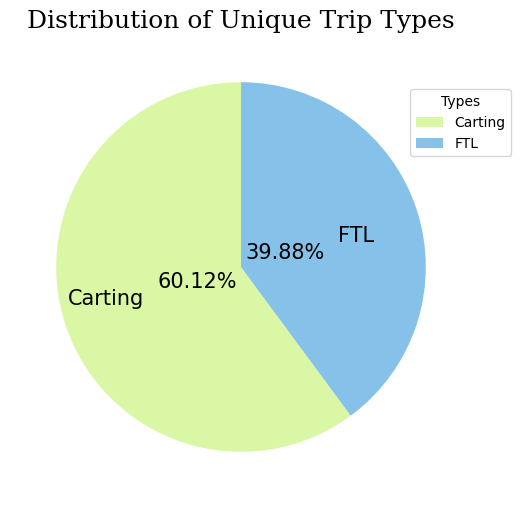

In [6]:
trip_type_df = data_df.drop_duplicates(subset=['trip_uuid'])[['route_type']]
trip_type_count = trip_type_df.value_counts()
unique_trip_type = trip_type_df['route_type'].unique()

font = {'family':'serif',
        'color': 'black',
        'weight': 'normal',
        'size': 18   
}

plt.figure(figsize=(6, 6))

patches, texts, autotexts = plt.pie(trip_type_count, labels=unique_trip_type, autopct='%1.2f%%', 
                                    colors=['#DAF7A6', '#85c1e9'], startangle=90, labeldistance=0.55, pctdistance=0.25)

plt.setp(texts, fontsize=15)
plt.setp(autotexts, fontsize=15)

plt.legend(title='Types', loc='upper right', bbox_to_anchor=(1, 0.9, 0.1, 0))

plt.title('Distribution of Unique Trip Types', fontdict=font)
plt.savefig('Distribution of Unique Trip Types')
plt.show()

**Goal**: Find the relationship between total actual distance and actual time taken for each trip. Each unique trip ID is considered as one trip.

**Note**: Calculate the actual time and distance from source to final destination for each trip ID by summing the actual times of all subsets of the package delivery. The actual time, where is_cutoff is FALSE, is the accumulated actual time of the delivery subset.  

**Conclusion**: The total actual distance from origin to destination and total atual time show a positive correlation, with a few trips located in the upper left corner being outliers, where the time taken is higher than the average.

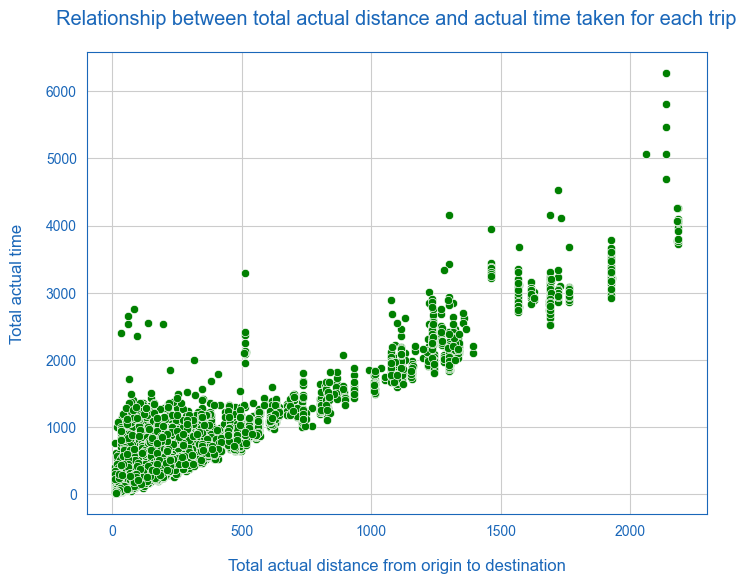

In [7]:
actual_time_df = data_df[data_df['is_cutoff']==False][['route_type','trip_uuid', 'is_cutoff', 'actual_distance_to_destination', 'actual_time']]
sum_columns = ['actual_distance_to_destination', 'actual_time']
first_columns = [col for col in actual_time_df.columns if col not in sum_columns and col!='trip_uuid']  

agg_dict = {col:'sum' for col in sum_columns}   # Apply 'sum' to 'actual_distance_to_destination' and 'actual_time'.
agg_dict.update({col:'first' for col in first_columns})   # Apply 'first' to other columns.

actual_time_df = actual_time_df.groupby(by='trip_uuid').agg(agg_dict).reset_index()
actual_time_df.rename(columns={'actual_distance_to_destination':'total_actual_distance_from_origin_to_destination', 'actual_time':'total_actual_time'}, inplace=True)

sns.set_style('whitegrid')
plt.figure(figsize=(8,6))
color = '#1a67b9'

sns.scatterplot(actual_time_df, x='total_actual_distance_from_origin_to_destination', y='total_actual_time', color='green')
plt.xlabel('Total actual distance from origin to destination', fontsize='large', color=color, labelpad=15)
plt.ylabel('Total actual time', fontsize='large', color=color, labelpad=15)
plt.title('Relationship between total actual distance and actual time taken for each trip', fontsize='x-large', color=color, pad=20)

ax = plt.gca()
for line in ['top', 'right', 'left', 'bottom']:
    ax.spines[line].set_color(color)
    
plt.tick_params(labelcolor=color)
plt.tick_params(color=color)
plt.savefig('Relationship between total actual distance and actual time taken for each trip')
plt.show()


**Goal**: Find the top 10 shipping origins and destinations with the highest number of shipping trips and arrival trips. 

**Note**: Consider rows with the same trip ID but different origin and destination as one trip. Delete duplicate rows where the origin, destination, and trip ID are all the same, except for the last occurrence.

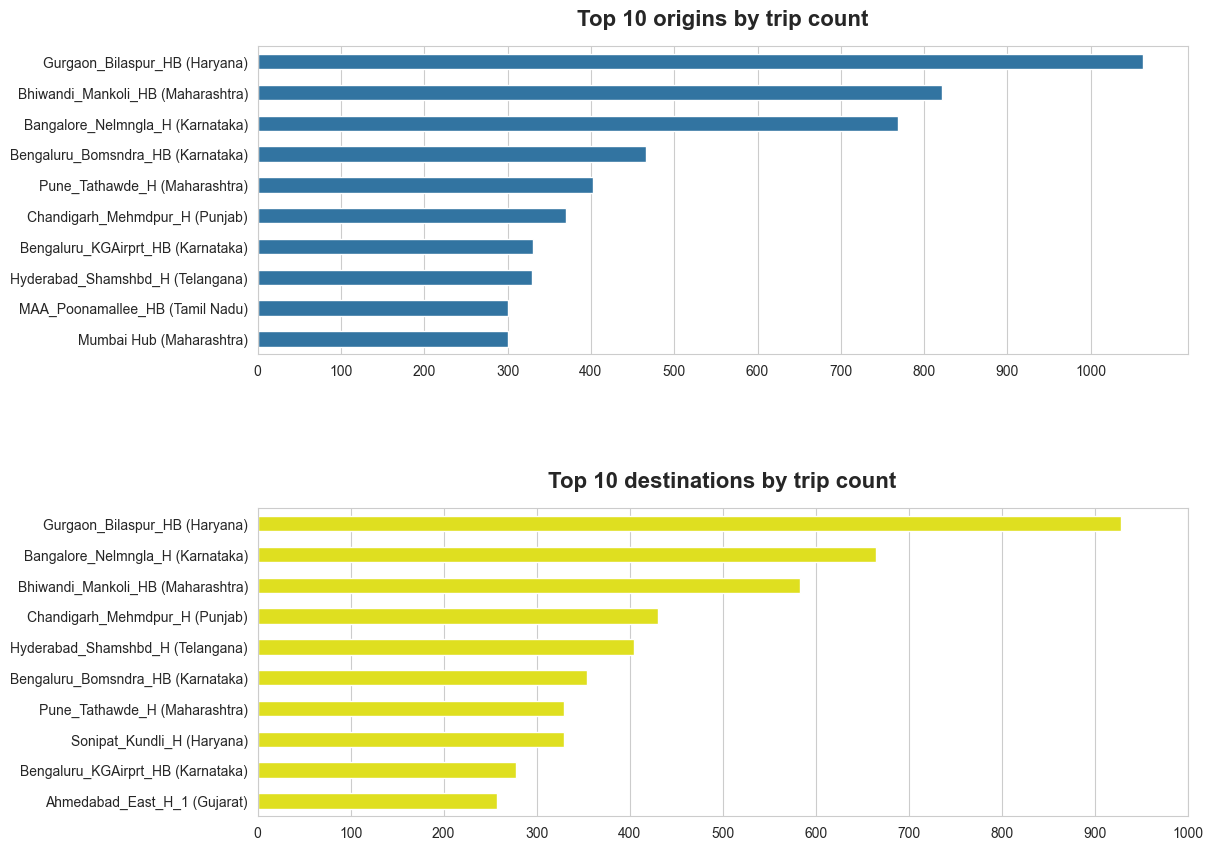

In [8]:
unique_df = data_df[['trip_uuid', 'source_name', 'destination_name']].drop_duplicates(subset=['trip_uuid', 'source_name', 'destination_name'], keep='last', ignore_index=True)
origin_count_top_10 = unique_df['source_name'].value_counts(ascending=False)[:10]
origin_count_top_10 = origin_count_top_10.reset_index()
destination_count_top_10 = unique_df['destination_name'].value_counts(ascending=False)[:10]
destination_count_top_10 = destination_count_top_10.reset_index()

plt.figure(figsize=(12,10))

plt.subplot(2,1,1)

sns.barplot(data=origin_count_top_10, x='count', y='source_name', width=0.5)
plt.xticks(np.arange(0, 1100, 100))
plt.ylabel('')
plt.xlabel('')
plt.title('Top 10 origins by trip count', fontsize=16, pad=15, weight='bold')

plt.subplot(2,1,2)
sns.set_style('whitegrid')
sns.barplot(data=destination_count_top_10, x='count', y='destination_name', width=0.5, color='yellow')
plt.xticks(np.arange(0, 1100, 100))
plt.ylabel('')
plt.xlabel('')
plt.title('Top 10 destinations by trip count',fontsize=16, pad=15, weight='bold')

plt.subplots_adjust(hspace=0.5)   # adjust the distance between 2 subplots

plt.savefig('Top 10 orgins and destinations by trip count')
plt.show()


**Goal**: Find the distribution of the difference between the actual time and the time calculated by the engine time calculator ORSM for each package delivery.

**Note**: present the maximum value, minimum value, mean, 25th percentile, 75th percentile, and outliers using KDE plot, boxplot, and describe().    Due to the large gap between the maximum and minimum values, the box plot and KDE plot cannot clearly display the specific values of the maximum, minimum, mean, 25th percentile, and 75th percentile. In this case, it is more appropriate to use the describe() function to obtain these values.

       segment_actual_time  segment_osrm_time      time_diff
count        144867.000000      144867.000000  144867.000000
mean             36.196111          18.507548      17.688563
std              53.571158          14.775960      49.010556
min            -244.000000           0.000000    -274.000000
25%              20.000000          11.000000       5.000000
50%              29.000000          17.000000      10.000000
75%              40.000000          22.000000      19.000000
max            3051.000000        1611.000000    2418.000000 



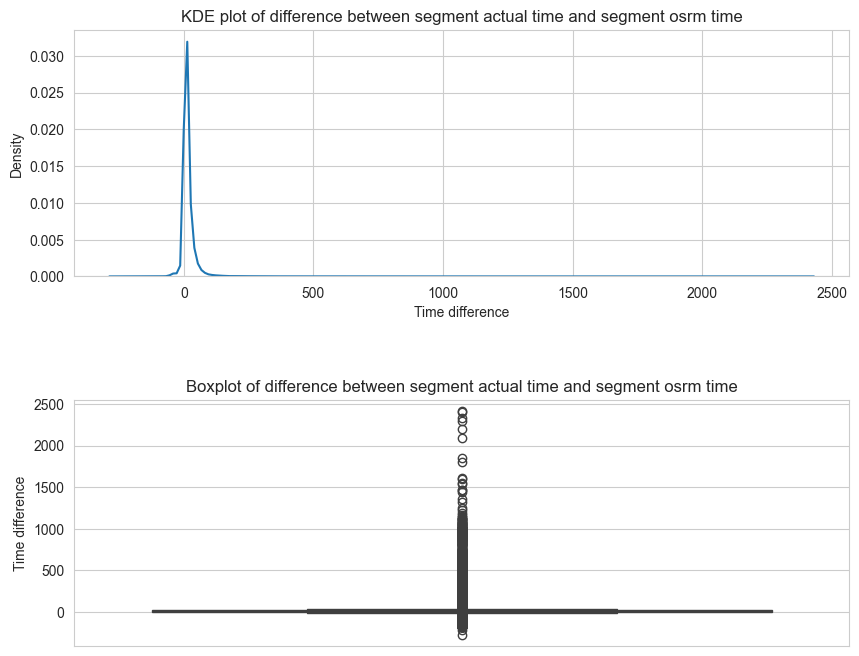

In [9]:
segment_time_df = data_df[['segment_actual_time','segment_osrm_time']]
segment_time_df = segment_time_df.copy()
segment_time_df['time_diff'] = segment_time_df['segment_actual_time'] - segment_time_df['segment_osrm_time']

print(segment_time_df.describe(), '\n')

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
sns.kdeplot(segment_time_df['time_diff'])
plt.xlabel('Time difference')
plt.title('KDE plot of difference between segment actual time and segment osrm time')

plt.subplot(2,1,2)
sns.boxplot(segment_time_df['time_diff'])
plt.ylabel('Time difference')
plt.title('Boxplot of difference between segment actual time and segment osrm time')

plt.subplots_adjust(hspace=0.5)

plt.show()

**Goal**: Predict actual delivery time.

**Steps**:
1. According to domain knowledge, trip type(route_type), origin warehouse(source_center), destination warehouse(destination_center), delivery start time(od_start_time), actual delivery time(actual_time), and actual delivery distance(actual_distance_to_destination) are selected as features. Since some values in source_name and destination_center are unknown, select source_center and destination_center instead.
2. Keep only rows where is_cutoff is False, since their actual_time and actual_distance_to_destination are the accumulated time and distances of 1 trip between origin warehouses and destination warehouses.
3. Divide data into training set and testing set. There are only 26118 unique trip id in total. Thus, 10-fold cross-validation is applied to reduce overfitting. Allocate 10% of data for testing, the remaining 90% data for training.
4. Skewness of actual_time and actual_distance_to_destination are 4.75 and 5.14 respectively, which means they are highly right-skewed. Thus, a transformation to reduce skewness is needed to reduce the influence of outliers and make the distribution more normal-like before using Z-Score Standardization. Choose log transformation since it is effective for highly right-skewed.
5. Preprocess trans_actual_distance_to_destination into actual_distance_to_destination_scaled with Z-StandardScaler to prevent features with different ranges from distorting the model. Target is actual_distance_to_destination_scaled.
6. Split od_start_time into year, month, day, hour and determine if the day is an india holiday or weekday. Barplots 'Counts of month' and 'Counts of year' show that all deliveries are in September 2018 or October 2018. Thus, do not select year as a feature. Month, day, day_of_week, is_weekend and time_of_day are features.
7. Transform route_type into the numerical variable route_type_num. If route_type is Carting, then 1. If it is FTL, then 0.
8. Encode month, day and time_of_day with Cyclic Encoding.
9. Encode source_center and destination_center with target encoding, because target encoding captures relationships between source_center or destination_center and actual_time. To avoid overfitting, apply 10-fold target encoding.
10. Create Linear Regression, Decision Tree, Random Forest, Gradient Boosting, KNN, SVR and MLP Regressor models. Use mean squared error, mean absolute error, median absolute error and R-squared to evaluate the performance of predictive models. Since the dataset is small, regularize models except for Linear Regression to avoid overfitting.

**Result**:

Models perform well but very overfitting because all errors are small. The main reason of overfitting is the dataset only consists of 26118 data and lacks variability. E.g., all dates fall within September and October, thus models capture temporal patterns easily.   


count of rows: 26118


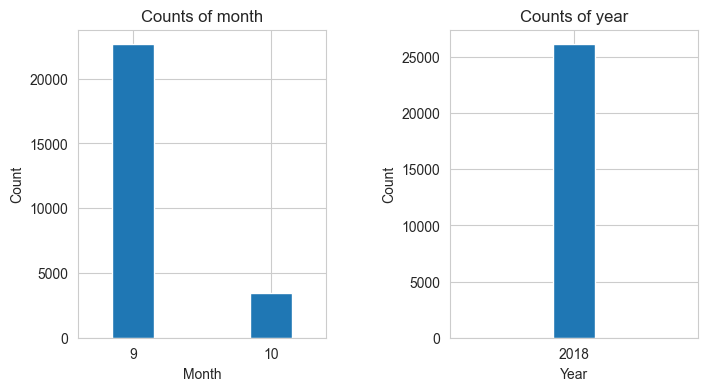

In [10]:
delivery_df = data_df[['route_type', 'trip_uuid', 'source_center', 'destination_center', 'od_start_time', 'actual_distance_to_destination', 'actual_time', 'is_cutoff']]
delivery_df = delivery_df[delivery_df['is_cutoff']==False]
delivery_df.reset_index(drop=True, inplace=True)

print('count of rows:', delivery_df['trip_uuid'].count())

# no na 
delivery_df.isnull().sum()

delivery_df['od_start_time'] = pd.to_datetime(delivery_df['od_start_time'])
delivery_df['year'] = delivery_df['od_start_time'].dt.year
delivery_df['month'] = delivery_df['od_start_time'].dt.month
delivery_df['day'] = delivery_df['od_start_time'].dt.day
delivery_df['date'] = delivery_df['od_start_time'].dt.date
delivery_df['day_of_week'] = delivery_df['od_start_time'].dt.weekday

month_counts = delivery_df['month'].value_counts()
year_counts = delivery_df['year'].value_counts()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
month_counts.plot(kind='bar', width=0.3)
plt.title('Counts of month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1,2,2)
year_counts.plot(kind='bar', width=0.1)
plt.title('Counts of year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplots_adjust(wspace=0.5)
plt.show()


In [11]:
# calculate skewness
skweness_actual_time = skew(delivery_df['actual_time'])
print('skewness of actual_time: ', skweness_actual_time)

skweness_actual_distance_to_destination = skew(delivery_df['actual_distance_to_destination'])
print('skewness of actual_distance_to_destination: ', skweness_actual_distance_to_destination)

# apply transformation to reduce skewness
delivery_df['trans_actual_time'] = np.log1p(delivery_df['actual_time'])
delivery_df['trans_actual_distance_to_destination'] = np.log1p(delivery_df['actual_distance_to_destination'])

# standardize actual_distance_to_destination with Z-Score Standardization
z_scaler = StandardScaler()
delivery_df['actual_distance_to_destination_scaled'] = z_scaler.fit_transform(delivery_df[['trans_actual_distance_to_destination']])

# transform route_type into a numerical variable. if route_type is Carting, then 1. If it is FTL, then 0.
delivery_df['route_type_num'] = delivery_df['route_type'].apply(lambda x: 1 if x=='Carting' else 0)

# if the day is not a weekday, then 1, else 0
delivery_df['is_weekend'] = delivery_df['day_of_week'].apply(lambda x: 1 if x>=5 else 0)

# if the day is a holidy, then 1, else 0
india_holidays = holidays.country_holidays('India')
delivery_df['is_holiday'] = delivery_df['date'].apply(lambda x: 1 if x in india_holidays else 0)

# categorize time into 0 (day 6 AM - 6 PM), 1 (evening 6 PM - 6 AM)
delivery_df['hour'] = delivery_df['od_start_time'].dt.hour
delivery_df['time_of_day'] = delivery_df['hour'].apply(lambda x: 1 if 6<=x<18 else 0)

# cyclic encoding for month and day 
delivery_df['month_sin'] = np.sin(2*np.pi*delivery_df['month']/12)
delivery_df['month_cos'] = np.cos(2*np.pi*delivery_df['month']/12)
delivery_df['day_sin'] = np.sin(2*np.pi*delivery_df['day']/31)
delivery_df['day_cos'] = np.cos(2*np.pi*delivery_df['day']/31)
delivery_df['day_of_week_sin'] = np.sin(2*np.pi*delivery_df['day_of_week']/7)
delivery_df['day_of_week_cos'] = np.cos(2*np.pi*delivery_df['day_of_week']/7)

# split delivery_df into features and target
X = delivery_df[['source_center', 'destination_center', 'actual_distance_to_destination_scaled', 'route_type_num', 'is_weekend', 'is_holiday', 'time_of_day', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos']]
y = delivery_df['actual_distance_to_destination_scaled']

# intialize 10-fold cross-validation
kf = KFold(n_splits=10)

# intialize target encoding
target_encoder = ce.TargetEncoder(cols=['source_center', 'destination_center'])

mse_scores = {}


# Except for Linear Regression, other models can easily overfit the dataset which only includes 26118 data. Thus, regularization is necessary to improve generalization.
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, min_samples_split=10, min_samples_leaf=5),
    'Random Forest': RandomForestRegressor(max_depth=10, min_samples_leaf=5),
    'Gradient Boosting': GradientBoostingRegressor(learning_rate=0.05,subsample=0.7, max_features='sqrt', min_samples_split=10, min_samples_leaf=5),  # reduce learning rate and subsample and limit maximum number of features to avoid overfitting.
    'KNN': KNeighborsRegressor(n_neighbors=10, weights='distance'),
    'SVR': SVR(C=0.5, epsilon=0.2, gamma=0.1),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(50, 30),alpha=0.01, max_iter=500)
}


for model_name, model in models.items():
    fold_scores_dict = {'MSE':[], 'MAE':[], 'MedAE':[], 'R2':[]}

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        # apply target encoding to 'source_center', 'destination_center'
        target_encoder.fit(X_train[['source_center', 'destination_center']], y_train)
        X_train_encoded = target_encoder.transform(X_train[['source_center', 'destination_center']])
        X_test_encoded = target_encoder.transform(X_test[['source_center', 'destination_center']])
    
        X_train_encoded = pd.concat([X_train_encoded, X_train.drop(columns=['source_center', 'destination_center'])], axis=1)
        X_test_encoded = pd.concat([X_test_encoded, X_test.drop(columns=['source_center', 'destination_center'])], axis=1)
    
        model.fit(X_train_encoded, y_train)

        # save models
        model_path = os.path.join(r'Model folder path', f'{model_name}.pkl')
        joblib.dump(model, model_path)
        
        y_predict = model.predict(X_test_encoded)
        mse = mean_squared_error(y_test, y_predict)
        mae = mean_absolute_error(y_test, y_predict)
        madae = median_absolute_error(y_test, y_predict)
        r2 = r2_score(y_test, y_predict)
        
        fold_scores_dict['MSE'].append(mse)
        fold_scores_dict['MAE'].append(mae)
        fold_scores_dict['MedAE'].append(madae)
        fold_scores_dict['R2'].append(r2)

    average_mse = np.mean(fold_scores_dict['MSE'])
    average_mae = np.mean(fold_scores_dict['MAE'])
    average_medae = np.mean(fold_scores_dict['MedAE'])
    average_r2 = np.mean(fold_scores_dict['R2'])
    
    print(f'{model_name} Average MSE: {average_mse}, Average MAE = {average_mae}, Average MedAE = {average_medae}, Average R2 = {average_r2}')

skewness of actual_time:  4.754749692742883
skewness of actual_distance_to_destination:  5.137805474709305
Linear Regression Average MSE: 8.627276258018282e-31, Average MAE = 6.2505908152884e-16, Average MedAE = 4.593547764386585e-16, Average R2 = 1.0
Decision Tree Average MSE: 2.3461315746451594e-06, Average MAE = 0.0010206287470249315, Average MedAE = 0.0009260044055119582, Average R2 = 0.9999976399527201
Random Forest Average MSE: 1.09652028349542e-06, Average MAE = 0.0003266450927878476, Average MedAE = 0.00021378363773780462, Average R2 = 0.999998888983192
Gradient Boosting Average MSE: 0.03481368326999824, Average MAE = 0.13233632294311656, Average MedAE = 0.0932718310792126, Average R2 = 0.9652456054164485
KNN Average MSE: 0.007980955764682184, Average MAE = 0.05333671292673177, Average MedAE = 0.02641190212875344, Average R2 = 0.9920016490827697
SVR Average MSE: 0.014802444333061831, Average MAE = 0.10957320986888201, Average MedAE = 0.11096853437151384, Average R2 = 0.98514146